In [101]:
import pandas as pd
from matplotlib.figure import Figure
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from copy import copy
from select_molecole_entity_value import select_molecule_entity_value

#建立连接
conn = pymysql.connect(
	host="114.116.114.149",
	port=10022,
	user="exomics_admin",
	passwd="exomics_2022",
	db='exOmics'
)

#设定要查询的数据类型和基因
gene = 'ENSG00000000457' #基因主页所对应的基因
feature = 'altp' #此处值是范例，实际上需要根据网页决定
dataset = 'gse68086' #此处值是范例，实际上需要根据网页决定
specimen = 'tep' #此处值是范例，实际上需要根据网页决定

#以下变量由上述选择自动决定，因为具有关联性
# molecule = 'cfrna'
# entity = 'entity'
# value = 'count'
molecule, entity, value = select_molecule_entity_value(dataset, feature, specimen, conn)


#根据以上条件查询所有可能的疾病类型
sql_disease = f"""
	SELECT ori.Disease_condition
	FROM (
        SELECT SUBSTRING_INDEX(TABLE_NAME,'-',1) AS NT,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-6),'-',1) AS Omics,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-5),'-',1) AS Dataset,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-4),'-',1) AS Entity,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-3),'-',1) AS Disease_condition,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-2),'-',1) AS Specimen,
			SUBSTRING_INDEX(TABLE_NAME,'-',-1) AS Value_type
		FROM information_schema.`TABLES`
		WHERE table_schema='exOmics'
			AND (
                TABLE_NAME LIKE '%gse%'
				OR TABLE_NAME LIKE '%prjeb%'
				OR TABLE_NAME LIKE '%prjna%'
				OR TABLE_NAME LIKE '%gse%'
				OR TABLE_NAME LIKE '%srp%'
				OR TABLE_NAME LIKE '%pxd%'
            )
            AND TABLE_NAME NOT LIKE '%gsea%'
        )ori
	WHERE Dataset LIKE '%{dataset}%'
		AND Omics LIKE '%{feature}%'
        AND Disease_condition NOT LIKE '%mean%'
"""
diseases = pd.read_sql_query(sql_disease, conn)

#查询语句
diseases_data = pd.DataFrame()
for disease in diseases['Disease_condition']:
	query_sql = f"""
		SELECT c.*
		FROM `{molecule}-{feature}-{dataset}-{entity}-{disease}-{specimen}-{value}` c, gene_index g
		WHERE c.feature LIKE CONCAT('%',g.ensembl_gene_id,'%')
			AND g.ensembl_gene_id LIKE '%{gene}%'
	"""
	temp = pd.read_sql_query(query_sql, conn).set_index('feature').astype('float').mean(axis=1)
	temp = temp.to_frame()
	temp.columns = [disease.upper()]
	diseases_data = pd.concat([diseases_data,temp],axis=1)
diseases_data = diseases_data.T

/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQL

/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/var/folders/8x/k37pwt056lngr6zbd9cy0bj00000gn/T/ipykernel_21618/1952740648.py:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


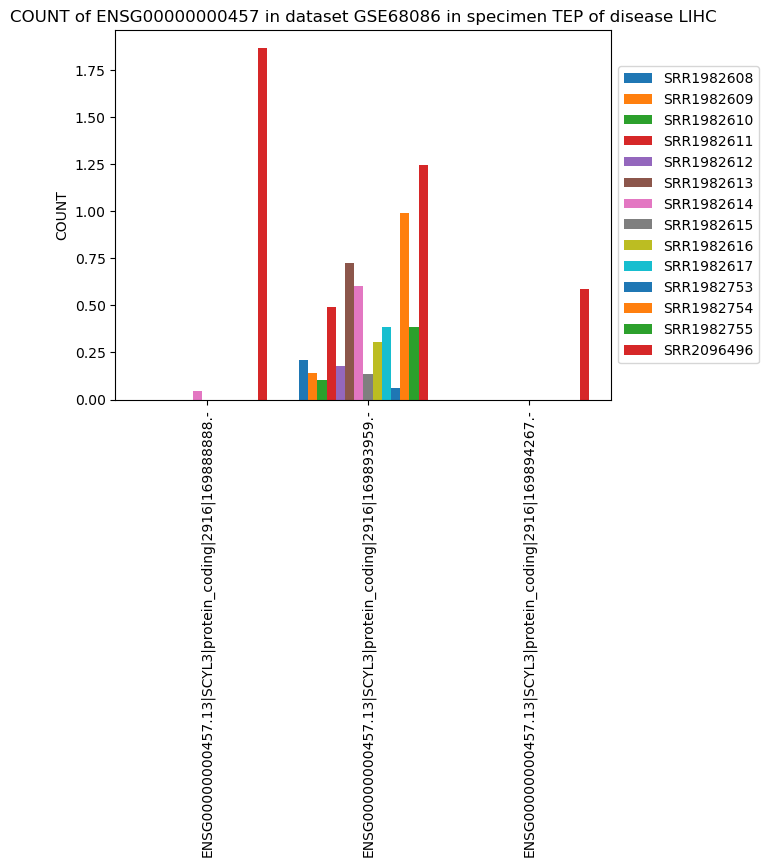

In [11]:
import pandas as pd
from matplotlib.figure import Figure
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from select_molecole_entity_value import select_molecule_entity_value

#建立连接
conn = pymysql.connect(
	host="114.116.114.149",
	port=10022,
	user="exomics_admin",
	passwd="exomics_2022",
	db='exOmics'
)

#设定要查询的数据类型和基因
gene = 'ENSG00000000457' #基因主页所对应的基因
feature = 'altp' #此处值是范例，实际上需要根据网页决定
dataset = 'gse68086' #此处值是范例，实际上需要根据网页决定
disease = 'lihc' #此处值是范例，实际上需要根据网页决定
specimen = 'tep' #此处值是范例，实际上需要根据网页决定

#以下变量由上述选择自动决定，因为具有关联性
# molecule = 'cfrna'
# entity = 'entity'
# value = 'count'
molecule, entity, value = select_molecule_entity_value(dataset, feature, specimen, conn)


#查询语句
query_sql = f"""
    SELECT c.*
    FROM `{molecule}-{feature}-{dataset}-{entity}-{disease}-{specimen}-{value}` c, gene_index g
    WHERE c.feature LIKE CONCAT('%',g.ensembl_gene_id,'%')
        AND g.ensembl_gene_id LIKE '%{gene}%'
"""

#获得表格，可以直接在网页中展示
table = pd.read_sql_query(query_sql, conn)
table.iloc[:,1:] = table.iloc[:,1:].astype('float')
table = table.set_index('feature') #feature列设为index

#作图
#将获得一个多行多列的表，每一行代表一个entity，每一列代表一个样本或一个疾病类型（当disease是mean时）。因此做barplot选择做dodged barplot (即grouped bat chart)。
x = np.arange(table.shape[0]) #行数向量
y = table.shape[1]
fig = Figure()
ax = fig.subplots()

width_all = 0.8
width = width_all/y  # the width of the bars
multiplier = 0
cmap = cm.ScalarMappable(cmap=mpl.cm.cool)

for coli in range(table.shape[1]): #每一列
    attribute = table.columns[coli] #第i列的列名
    measurement = table.iloc[:,coli] #第i列的数据
    offset = width * multiplier #每个group的偏移量
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel(f'{value.upper()}')
ax.set_title(f'{value.upper()} of {gene.upper()} in dataset {dataset.upper()} in specimen {specimen.upper()} of disease {disease.upper()}')
ax.set_xticks(x + width_all/2, list(table.index),rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig

In [2]:
plt.show()

In [87]:
diseases_data.values

array([[0.13774559, 0.24872782, 0.03104218],
       [0.02639793, 0.25235229, 0.03070052],
       [0.21779862, 1.06421165, 0.05894697],
       [0.0664337 , 0.46444915, 0.09894075],
       [0.1367335 , 0.42605836, 0.04202814],
       [0.07015402, 0.30903122, 0.03698462],
       [0.02776203, 0.19107094, 0.00852894]])

In [88]:
len(yLabel)

7